# SINDy-PI Feature Overview

This notebook provides a simple overview of the basic functionality of SINDy-PI implemented in PySINDy, and is written by Alan Kaptanoglu and Kadierdan Kaheman. SINDy-PI is used to handle generic implicit ODEs of the form,
$$ \frac{d}{dt}\mathbf{x} = \mathbf{f}(\mathbf{x}, \dot{\mathbf{x}}) \approx \mathbf{\Theta}(\mathbf{x}, \dot{\mathbf{x}})\mathbf{\Xi}$$
This is based off of the paper "Kaheman, K., Kutz, J. N., & Brunton, S. L. (2020). SINDy-PI: a robust algorithm for parallel implicit sparse identification of nonlinear dynamics. Proceedings of the Royal Society A, 476(2242), 20200279."

We should clarify that building SINDy libraries $\mathbf{\Theta}(\mathbf{x}, \dot{\mathbf{x}})$ depending on both $\mathbf{x}$ and $\dot{\mathbf{x}}$ is also possible with any of the PySINDy libraries. However, in that case one must be sure to omit the linear $\dot{\mathbf{x}}$ term in the library (since then the SINDy model will just fit $\dot{\mathbf{x}} = \dot{\mathbf{x}}$) and otherwise be careful about the matrix conditioning. The benefit of not using the SINDy-PI functionality is that you can avoid using SymPy (see below).

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.6?filepath=examples/9_sindypi_with_sympy.ipynb)

In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
from pysindy.utils import enzyme, bacterial
import sympy as sp
from scipy.integrate import solve_ivp

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# For reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# Example to show library functionality
Below, we define custom libraries for x and x_dot, showing that the resulting full library and library names are a tensor product of the two independent libraries. Note that to generate the constant function 1 without generating repeated entries, we need to use include_bias=True.

In [2]:
t = np.linspace(0, 1, 5)
x = np.ones((5, 2))

# Functions to be applied to the data x
functions = [lambda x: np.exp(x), lambda x, y: np.sin(x + y)]

# Functions to be applied to the data x_dot
x_dot_functions = [lambda x: x]

lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    t=t,
).fit(x)
lib.transform(x)
print("Without function names: ")
print(lib.get_feature_names(), "\n")

# Function names includes both the x and x_dot functions
function_names = [
    lambda x: "exp(" + x + ")",
    lambda x, y: "sin(" + x + y + ")",
    lambda x: x,
]
lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    function_names=function_names,
    t=t,
).fit(x)
lib.transform(x)
print("With function names: ")
print(lib.get_feature_names(), "\n")

# Now include a bias term (constant term)
lib = ps.SINDyPILibrary(
    library_functions=functions,
    x_dot_library_functions=x_dot_functions,
    function_names=function_names,
    t=t,
    include_bias=True,
).fit(x)
lib.transform(x)
print("With function names and bias term: ")
print(lib.get_feature_names())


Without function names: 
['f0(x0)', 'f0(x1)', 'f1(x0,x1)', 'f_dot0(x0_dot)', 'f_dot0(x1_dot)', 'f0(x0)f_dot0(x0_dot)', 'f0(x1)f_dot0(x0_dot)', 'f1(x0,x1)f_dot0(x0_dot)', 'f0(x0)f_dot0(x1_dot)', 'f0(x1)f_dot0(x1_dot)', 'f1(x0,x1)f_dot0(x1_dot)'] 

With function names: 
['exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_dot', 'x1_dot', 'exp(x0)x0_dot', 'exp(x1)x0_dot', 'sin(x0x1)x0_dot', 'exp(x0)x1_dot', 'exp(x1)x1_dot', 'sin(x0x1)x1_dot'] 

With function names and bias term: 
['1', 'exp(x0)', 'exp(x1)', 'sin(x0x1)', 'x0_dot', 'x1_dot', 'exp(x0)x0_dot', 'exp(x1)x0_dot', 'sin(x0x1)x0_dot', 'exp(x0)x1_dot', 'exp(x1)x1_dot', 'sin(x0x1)x1_dot']


### Solve 1D Michelson-Menten enzyme model as first demonstration
The Michelson-Menten enzyme model is,
$$\dot{x} = 0.6 - \frac{1.5 x}{0.3 + x}.$$
Note that, instead of dealing with fractional terms, it can be rearranged into
$$\dot{x} = \frac{3}{5} -3 x - \frac{10}{3} x\dot{x},$$
which is an implicit ODE, since the right-hand-side now depends on $\dot{x}$! In order to handle this scenario, SINDy-PI builds a candidate library with terms depending on both $x$ and $\dot{x}$, and solves the optimization problem, 
$$\|\Theta(x, \dot{x}) - \Theta(x, \dot{x})\Xi\|_2 + \lambda\|\Xi\|_1, \quad s.t. \text{diag}(\Xi) = 0.$$
This reason this modified optimization is required is that linear terms in $\dot{x}$ are no longer guaranteed, so every candidate library term is fit with a different model to find the best combination of implicit terms. Note $\text{diag}(\Xi) = 0$ is required because without this, the model would just fit every candidate library term with itself, $\dot{x} = \dot{x}$, $x\dot{x} = x\dot{x}$, $x^2\dot{x} = x^2\dot{x}$, and so on.

In [3]:
# define parameters
r = 1
dt = 0.001
T = 4
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0_train = [0.55]
x_train = solve_ivp(enzyme, t_span, x0_train, t_eval=t, **integrator_keywords).y.T

# Initialize custom SINDy library so that we can have x_dot inside it. 
x_library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
]
x_dot_library_functions = [lambda x: x]

# library function names includes both 
# the x_library_functions and x_dot_library_functions names
library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: x,
]

# Need to pass time base to the library so can build the x_dot library from x
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t[1:-1],
    function_names=library_function_names,
    include_bias=True,
)

# Use the SINDy-PI optimizer, which relies on CVXPY.
# Note that if LHS of the equation fits the data poorly,
# CVXPY often returns failure.
sindy_opt = ps.SINDyPI(
    threshold=1e-6,
    tol=1e-8,
    thresholder="l1",
    max_iter=20000,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)
model.print()

(4002, 1) 4002
Solver failed on model  3 , setting coefs to zeros
1 = 5.000 x0 + 1.667 x0_dot + 5.556 x0x0_dot
x0 = 0.200 1 + -0.333 x0_dot + -1.111 x0x0_dot
x0x0 = 0.198 x0 + 0.007 x0x0x0 + -0.338 x0x0_dot + -1.099 x0x0x0_dot
x0x0x0 = 0.000
x0x0x0x0 = -0.001 1 + 0.363 x0x0x0 + 0.041 x0x0_dot + -1.205 x0x0x0x0x0_dot
x0_dot = 0.600 1 + -3.000 x0 + -3.333 x0x0_dot
x0x0_dot = 0.180 1 + -0.900 x0 + -0.300 x0_dot
x0x0x0_dot = -0.004 1 + 0.136 x0 + -0.508 x0x0 + -0.344 x0x0x0 + -0.102 x0x0_dot + -0.219 x0x0x0x0x0_dot
x0x0x0x0_dot = 0.003 1 + 0.001 x0 + -0.391 x0x0x0 + -0.247 x0x0x0x0 + -0.108 x0x0_dot
x0x0x0x0x0_dot = 0.001 1 + -0.670 x0x0x0x0 + -0.005 x0_dot + 0.029 x0x0_dot + -0.271 x0x0x0_dot


### Okay, so how to choose which model to use?
So SINDy-PI has generated a different dynamical model for each of the candidate library terms, but how do we choose which one to use? This can be decided in many ways, but an easy choice is picking the model that minimizes the mean-squared error of the $\dot{x}$ testing data. There are many other ways to choose, and the SINDy-PI paper noted that bad models tend to also be less sparse, so sparsity is another metric for selection. Below, we simply integrate forward all the models and on this testing trajectory, they basically all perform fine. 

(4002, 1) 4002


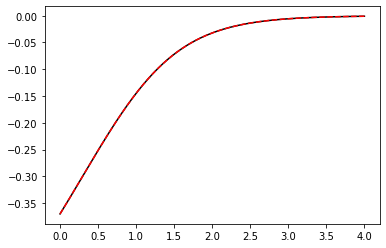

In [4]:
# Plot the fit of the derivative
x_dot_train = model.differentiate(x_train, t)
x_dot_train_pred = sindy_opt.Theta_ @ sindy_opt.coef_.T
plt.figure()
for i in range(r):
    plt.subplot(1, r, i + 1)
    plt.plot(t, x_dot_train[:, i], 'k')
    plt.plot(t[1:-1], x_dot_train_pred[:, 5], 'r--')

### Now we need to reformat all the feature strings for conversion into symbolic variables
So we have all these nice models but these are implicit ODEs, and the default Python solvers (solve_ivp and odeint) cannot solve implicit ODEs. There are two options although we only illustrate the first option below; we must convert the equations into symbolic variables and then either (1) use SymPy to symbolically solve the equation for $\dot{x}$, after which the equation is no longer implicit and can be solved with the default Python solves, or (2) convert the equations into a symbolic differential algebraic equation (DAE), which can be numerically solved with the diffeqpy Python package (but requires Julia to be installed). 

In [5]:
features = model.get_feature_names()
features[0] = "1"
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy
print(features)
print(features_formatted)
coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]

['1', 'x0', 'x0x0', 'x0x0x0', 'x0x0x0x0', 'x0_dot', 'x0x0_dot', 'x0x0x0_dot', 'x0x0x0x0_dot', 'x0x0x0x0x0_dot']
['1', 'x0', 'x0 * x0', 'x0 * x0 * x0', 'x0 * x0 * x0 * x0', 'x0_dot', 'x0 * x0_dot', 'x0 * x0 * x0_dot', 'x0 * x0 * x0 * x0_dot', 'x0 * x0 * x0 * x0 * x0_dot']


### Check all the model fits produce sensible models

In [6]:
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    sym_equations.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 10)), sym_features[i]
        )
    )
    sym_equations_rounded.append(
        sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 2)), sym_features[i]
        )
    )
    print(sym_theta[i], " = ", sym_equations_rounded[i][0])


1  =  5.0*x0 + 1.67*x0_dot + 5.56*x0x0_dot
x0  =  0.2*1 - 0.33*x0_dot - 1.11*x0x0_dot
x0x0  =  0.2*x0 - 0.34*x0x0_dot + 0.01*x0x0x0 - 1.1*x0x0x0_dot
x0x0x0  =  0
x0x0x0x0  =  0.04*x0x0_dot + 0.36*x0x0x0 - 1.21*x0x0x0x0x0_dot
x0_dot  =  0.6*1 - 3.0*x0 - 3.33*x0x0_dot
x0x0_dot  =  0.18*1 - 0.9*x0 - 0.3*x0_dot
x0x0x0_dot  =  0.14*x0 - 0.51*x0x0 - 0.1*x0x0_dot - 0.34*x0x0x0 - 0.22*x0x0x0x0x0_dot
x0x0x0x0_dot  =  -0.11*x0x0_dot - 0.39*x0x0x0 - 0.25*x0x0x0x0
x0x0x0x0x0_dot  =  -0.01*x0_dot + 0.03*x0x0_dot - 0.27*x0x0x0_dot - 0.67*x0x0x0x0


### Now we will:
1. reformat all the equations
2. solve symbolically for x_dot 
3. integrate and plot the new equations for x_dot

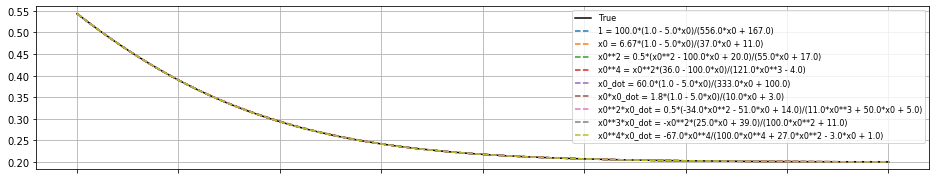

In [7]:
# Define the ODE symbol variables
t_sym = sp.symbols("t_sym")
x_sym = sp.symbols("x:%d" % r)
x_dot_sym = sp.symbols("x:%d_dot" % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
sym_equations_rounded_formatted = []
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_rounded_string = str(sym_equations_rounded[i]).replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        temp_rounded_string = temp_rounded_string.replace(
            "x" + str(j) + "x", "x" + str(j) + " * x"
        )
        sym_equations_formatted.append(temp_string)
        sym_equations_rounded_formatted.append(temp_rounded_string)

# Now that the equations are mathematically formatted, 
# solve for x_dot0 in the algebraic equation.
sym_equations_simplified = []
sym_equations_rounded_simplified = []
for i in range(nfeatures):
    sym_equations_simplified.append(
        sp.solve(
            sp.Add(
                sp.sympify(sym_equations_formatted)[i][0],
                -sp.sympify(features_formatted[i]),
            ),
            x_dot_sym,
        )
    )
    rounded = sp.solve(
        sp.Add(
            sp.sympify(sym_equations_rounded_formatted)[i][0],
            -sp.sympify(features_formatted[i]),
        ),
        x_dot_sym,
    )
    if len(rounded) != 0:
        rounded_temp = rounded[0]
        for a in sp.preorder_traversal(rounded):
            if isinstance(a, sp.Float):
                rounded_temp = rounded_temp.subs(a, round(a, 2))
        sym_equations_rounded_simplified.append(rounded_temp)
    else:
        sym_equations_rounded_simplified.append([])

# Plot the results for each of the models
plt.figure(figsize=(16, 3))
x0_test = np.random.rand(1)
x_test = solve_ivp(enzyme, t_span, x0_test, t_eval=t).y.T
plt.plot(t, x_test, color="k", linestyle="solid", label="True")
for i in range(nfeatures):
    ax = plt.gca()
    if i != nfeatures - 1:
        ax.set_xticklabels([])
    if len(sym_equations_simplified[i]) != 0:
        ODE_Func = sp.lambdify([t_sym, x_sym], sym_equations_simplified[i][0])

        # Now simulate the system we identified
        x_test_sim = solve_ivp(ODE_Func, t_span, x0_test, t_eval=t).y.T
        if (
            np.linalg.norm(x_test_sim) < 1e3
            and sym_equations_rounded_simplified[i] != 0
        ):
            plt.plot(
                t,
                x_test_sim,
                linestyle="dashed",
                label=str(sp.sympify(features_formatted[i]))
                + " = "
                + str(sym_equations_rounded_simplified[i]),
            )
plt.grid(True)
plt.legend(fontsize=8)

### We will now try a 2D example, the bacterial competence system (Mangan et al. 2016)
$$ \begin{aligned} \dot{x} &= a_1 + \frac{a_2x^2}{a_3 + x^2} - \frac{x}{1 + x + y} \\  \dot{y} &= \frac{b_1}{1 + b_2 x^5} - \frac{y}{1 + x + y} \end{aligned} $$
with $a_1=0.004$, $a_2=0.07$, $a_3=0.04$, $b_1=0.82$, $b_2=1854.5$. Note that multi-variable SymPy will require some changes, and multi-variable SINDy-PI typically requires many trajectories to correctly identify models.

In [8]:
# define parameters
r = 2
dt = 0.01
T = 20
t_train = np.arange(0, T + dt, dt)
t_train_span = (t_train[0], t_train[-1])

# Typically need at least 20-40 trajectories for a decent model.
# Note that this can be fairly time-consuming.
n_trajectories = 10
x_train_multi = []
t_train_multi = []
x0 = np.random.rand(n_trajectories, 2)
for i in range(n_trajectories):
    x_train_multi.append(solve_ivp(bacterial, t_train_span, 
                                   x0[i, :], t_eval=t_train, 
                                   **integrator_keywords).y.T)
    t_train_multi.append(t_train[1:-1])

# Initialize custom SINDy library up to sixth order polynomials
x_library_functions = [
    lambda x: x,
    lambda x, y: x * y,
    lambda x: x ** 2,
    lambda x, y, z: x * y * z,
    lambda x, y: x * y ** 2,
    lambda x: x ** 3,
    lambda x, y, z, w: x * y * z * w,
    lambda x, y, z: x * y * z ** 2,
    lambda x, y: x * y ** 3,
    lambda x: x ** 4,
    lambda x: x ** 5,
    lambda x: x ** 6,
]
x_dot_library_functions = [lambda x: x]

library_function_names = [
    lambda x: x,
    lambda x, y: x + y,
    lambda x: x + x,
    lambda x, y, z: x + y + z,
    lambda x, y: x + y + y,
    lambda x: x + x + x,
    lambda x, y, z, w: x + y + z + w,
    lambda x, y, z: x + y + z + z,
    lambda x, y: x + y + y + y,
    lambda x: x + x + x + x,
    lambda x: x + x + x + x + x,
    lambda x: x + x + x + x + x + x,
    lambda x: x,
]

# Get the indices of the equations for x0_dot and x1_dot
lib = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=t_train,
    function_names=library_function_names,
    include_bias=True,
).fit(np.asarray(x_train_multi)[0, :, :])
lib.transform(np.asarray(x_train_multi)[0, :, :])
features = np.asarray(lib.get_feature_names())
ind1 = int(np.ravel(np.where(features == "x0_dot"))[0] - 1)  # -1 because bias term
ind2 = int(np.ravel(np.where(features == "x1_dot"))[0] - 1)

# Need to flatten t_train_multi before passing time base to SINDyPILibrary
sindy_library = ps.SINDyPILibrary(
    library_functions=x_library_functions,
    x_dot_library_functions=x_dot_library_functions,
    t=np.ravel(np.asarray(t_train_multi)),
    function_names=library_function_names,
)

# Note, using model_subset (list of indices) to only compute two of the fits
sindy_opt = ps.SINDyPI(
    threshold=10,
    tol=1e-5,
    thresholder="l1",
    max_iter=20000,
    model_subset=[ind1, ind2],
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train_multi, t=dt, multiple_trajectories=True)
model.print()

x0 = 0.000
x1 = 0.000
x0x1 = 0.000
x0x0 = 0.000
x1x1 = 0.000
x0x1x1 = 0.000
x0x0x0 = 0.000
x1x1x1 = 0.000
x0x1x1x1 = 0.000
x0x0x0x0 = 0.000
x1x1x1x1 = 0.000
x0x0x0x0x0 = 0.000
x1x1x1x1x1 = 0.000
x0x0x0x0x0x0 = 0.000
x1x1x1x1x1x1 = 0.000
x0_dot = -0.410 x0 + 0.007 x1 + 0.021 x0x1
x1_dot = 0.010 x0 + 0.244 x1 + -0.332 x1x1 + 0.082 x1x1x1x1 + -0.020 x1x1x1x1x1 + 0.001 x1x1x1x1x1x1 + 0.773 x0x1_dot + 1.044 x1x1_dot + -0.009 x1x1x1x1x1x1x1_dot
x0x0_dot = 0.000
x1x0_dot = 0.000
x0x1x0_dot = 0.000
x0x0x0_dot = 0.000
x1x1x0_dot = 0.000
x0x1x1x0_dot = 0.000
x0x0x0x0_dot = 0.000
x1x1x1x0_dot = 0.000
x0x1x1x1x0_dot = 0.000
x0x0x0x0x0_dot = 0.000
x1x1x1x1x0_dot = 0.000
x0x0x0x0x0x0_dot = 0.000
x1x1x1x1x1x0_dot = 0.000
x0x0x0x0x0x0x0_dot = 0.000
x1x1x1x1x1x1x0_dot = 0.000
x0x1_dot = 0.000
x1x1_dot = 0.000
x0x1x1_dot = 0.000
x0x0x1_dot = 0.000
x1x1x1_dot = 0.000
x0x1x1x1_dot = 0.000
x0x0x0x1_dot = 0.000
x1x1x1x1_dot = 0.000
x0x1x1x1x1_dot = 0.000
x0x0x0x0x1_dot = 0.000
x1x1x1x1x1_dot = 0.000
x0x0x0x

(2002, 2) 2002


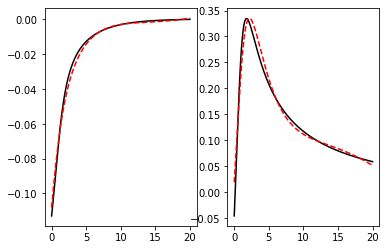

In [9]:
# Plot the fit of the derivative
x_train = np.asarray(x_train_multi)[0, :, :]
x_dot_train = model.differentiate(x_train, t_train)
x_dot_train_pred = sindy_opt.Theta_[:len(t_train) - 2, :] @ sindy_opt.coef_.T
plt.figure()
inds = [ind1, ind2]
for i in range(r):
    plt.subplot(1, r, i + 1)
    plt.plot(t_train, x_dot_train[:, i], 'k')
    plt.plot(t_train[1:-1], x_dot_train_pred[:, inds[i]], 'r--')

#### SINDy-PI model is not good here, but we proceed anyways to illustrate how to do the symbolic solve + integration in more than 1 dimensions.

In [10]:
# Repeat formatting the feature names and building the symbolic equations
features = model.get_feature_names()
nfeatures = len(features)
features[0] = "1"
features_copy = list(np.copy(features))
nfeatures = len(features)
features_formatted = []
# Need to put multiplication between terms for sympy
for i in range(nfeatures):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = features[i].replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        temp_string = temp_string.replace("x" + str(j) + "x", "x" + str(j) + " * x")
        features[i] = temp_string
    features_formatted.append(temp_string)
features = features_copy

coefs = model.coefficients()
sym_features = [sp.symbols(feature) for feature in features]
sym_theta = [sp.symbols(feature) for feature in features]
sym_equations = []
sym_equations_rounded = []
for i in range(nfeatures):
    if np.any(np.around(coefs[i], 2) != 0.0):
        sym_equation = sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 6)), sym_features[i]
        )
        sym_equations.append(sym_equation)
        sym_equation_rounded = sp.solve(
            sp.Eq(sym_theta[i], sym_theta @ np.around(coefs[i], 2)), sym_features[i]
        )
        sym_equations_rounded.append(sym_equation_rounded)


In [11]:
# Define the ODE symbol variables
t_sym = sp.symbols('t_sym')
x_sym = sp.symbols('x:%d' % r)
x_dot_sym = sp.symbols('x:%d_dot' % r)

# Need to format the above equations so that there are space between x0 * x0, x0 * x_dot0, and so on.
sym_equations_formatted = []
for i in range(len(sym_equations)):
    for j in range(r):
        # Overkill to make sure all the x0, x1, etc. get replaced
        temp_string = str(sym_equations[i]).replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        temp_string = temp_string.replace('x' + str(j) + 'x', 'x' + str(j) + ' * x')
        sym_equations[i] = temp_string
    sym_equations_formatted.append(temp_string)

# IMPORTANT change for multi-variable implicit equations:
# Now that the equations are mathematically formatted, 
# solve for x0_dot and x1_dot in the algebraic equation.
# Have two unknowns, (x0_dot, x1_dot), 
# so need to solve using two of ANY of the equations,
# but for simplicity we choose the equations for x0_dot and x1_dot.
sym_equations_simplified = sp.solve(
    (sp.Add(
        sp.sympify(sym_equations_formatted)[0][0], 
        - sp.sympify(features_formatted[ind1])), 
    sp.Add(
        sp.sympify(sym_equations_formatted)[1][0], 
        - sp.sympify(features_formatted[ind2]))),
    x_dot_sym)
print('Solved for xdot equations = ', sym_equations_simplified)

# Not the cleanest notation for multiple variables, but it works
ODE_Func = sp.lambdify([x_sym, t_sym], 
                       [sym_equations_simplified[x_dot_sym[0]], 
                        sym_equations_simplified[x_dot_sym[1]]])


Solved for xdot equations =  {x1_dot: (-1110.0*x1**6 + 20212.0*x1**5 - 82372.0*x1**4 + 331681.0*x1**2 - 243970.0*x1 - 9959.0)/(772811.0*x0 - 8754.0*x1**6 + 1044332.0*x1 - 1000000.0), x0_dot: 0.021224*x0*x1 + 3.1e-5*x1**6 - 0.000477*x1**4 + 0.007338*x1 - 0.410064}


#### We can simulate the system we identified but tends to be unstable -- need more memory to train on additional trajectories.